## Preamble

Questions/comments are prefixed by ''&lt;author&gt;:''.
***

In [1]:
import math, random #Jouke: Do we use the former? Can we not just use numpy for the latter?

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Input
from keras.layers import Reshape, UpSampling2D
import numpy as np

import powerlaw
import matplotlib.pyplot as plt
%matplotlib inline

pwl = powerlaw.Power_Law(xmin=1, discrete=True, parameters=[1.9])

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def py(d = 0.1):
    """Something akin to a Pitman-Yor process"""
    members = []
    
    while True:
        if len(members) < 1 or random.random() < d:
            draw = random.normalvariate(0, 1.0)
        else:
            draw = random.choice(members)
            
        yield draw
        members.append(draw)

gen = py(0.01)

def py_init(shape, dtype=None):
    """Custom weight initializer for Keras""" 
    arr = np.fromfunction(lambda *args: args[0]*0.0 + next(gen), shape=shape)
    return arr
#     return K.random_normal(shape, dtype=dtype)

## A Countable Model Class

We want a parameterized class of generative networks as models. The parameter values should such that, via a prefix-free encoding, they induce a _meaningful_ prior on the models. We desire a few properties:
- Every image of $N$ bits (uncompressed) can be generated by a model taking no input and having a prior probability as close to $2^{-N}$ as possible;
- There is a model taking $N$ bits of input such that every image of $N$ bits can be generated by it.

For convenience we may fix the size of the output image and pretend the size, $N$, is known to a model. To be completely thorough, this would add $\log N$ bits to the input of the model. The input of the model is treated as an enumeration of the images generated by it, so strictly speaking the model class should come with a way to scale models to arbitrary input sizes.

A large-ish image size limits the impact of small constants.

In [37]:
# The size of the generated image
height = width = 100
channels = 3

# Let's go with 4 bits per pixel per channel (4096 colors)
uncompressed = height * width * channels * 4

splits = sorted(np.random.choice(uncompressed - 1, 2, replace=False))
soph = splits[0] + 1
noise = splits[1] - splits[0]
redundancy = uncompressed - 1 - splits[1]

print('uncompressed  ', uncompressed)
print('sophistication', soph)
print('noise         ', noise)
print('redundancy    ', redundancy)

uncompressed   120000
sophistication 8714
noise          85022
redundancy     26264


We are now tasked with using `soph` bits to initiate a network that takes `noise` bits as input and generates `uncompressed` bits (shaped correctly) as output.
When choosing the `soph` bits and the `noise` bits randomly, then, with high probability, the generated image has a _sophistication_ and _noise_ close to `soph` and `noise`, respectively.

Here is an idea for filling in the weights in the network, after its topology has been determined (using some of the `soph` bits).
Use the available bits as a three part code:

1. Initialize a set of full-precision values (the size of the set is variable).
2. Specify the parameters of a probability distribution (in an appropriate class) on the set.
3. Encode each parameter (weight) in the network using an entropy encoding derived from the probability distribution.

Note that for a fixed topology, and values of `soph`, `noise` and `uncompressed`, the number of variables to be encoded in step three is known. This restriction guides the number of bits used in each of the steps.
In particular, we could simplify matters initially, by making the model class depend on a few (near-)constant sized parameters (for example, network depth and kernel size) and treat the sophistication as `soph / 32` floats (reduced precision to account for lack of proper encoding).
The specific model topology is then determined by the out-of-band parameters and the number of weights.

For statistical purposes, we should probably keep track of the depth of the networks used to generate an image. It is likely desirable to have a strong correlation between the depth and sophistication. In other words, the depth of the network should be monotonic in `soph`.

### Ad-hoc Model

Currently, the topology is a series of `numblocks` stacks of `blockdepth` consecutive 2D convolutions, separated by upsampling layers.
There is also a dense layer following the input.
This topology is fairly standard (http://cs231n.github.io/convolutional-networks/).

**Questions Jouke has**:
- To what extent is a this standard network layout (`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`, see the above Stanford link) theoretically invertible?
- What is the difference between convolutions and transpose convolutions (from https://arxiv.org/pdf/1603.07285.pdf I understand that each can be expressed as the other), and why do we prefer the former?

In [4]:
# Sample a model

# number of blocks of k convolutions and 
input_dim = int(pwl.generate_random()[0])
print('input_dim\t', input_dim)

num_channels = int(pwl.generate_random()[0])
print('num_channels\t', num_channels)

numblocks = random.randint(1,13) # this should be unbounded for a proper model class
print('numblocks\t', numblocks)

blockdepth = random.randint(1,7)
print('blockdepth\t', blockdepth)

kernelsize = random.randint(1,10)
print('kernelsize\t', kernelsize)



input_dim	 4
num_channels	 1
numblocks	 3
blockdepth	 7
kernelsize	 3


In [5]:
# Reset the PY weight generator
# gen=py(0.2)

encoded = Input(shape=(input_dim,))

x = Dense(256, activation='relu')(encoded)
x = Reshape((4,4,16))(x)

for n in range(numblocks):
    for b in range(blockdepth):
        x = Conv2D(num_channels, (kernelsize, kernelsize), activation='relu', padding='same', kernel_initializer=py_init)(x)
        
    x = UpSampling2D((2, 2))(x)
        
decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

decoder = Model(encoded, decoded)

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1280      
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 1)           145       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 1)           10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 1)           10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 1)           10        
__________

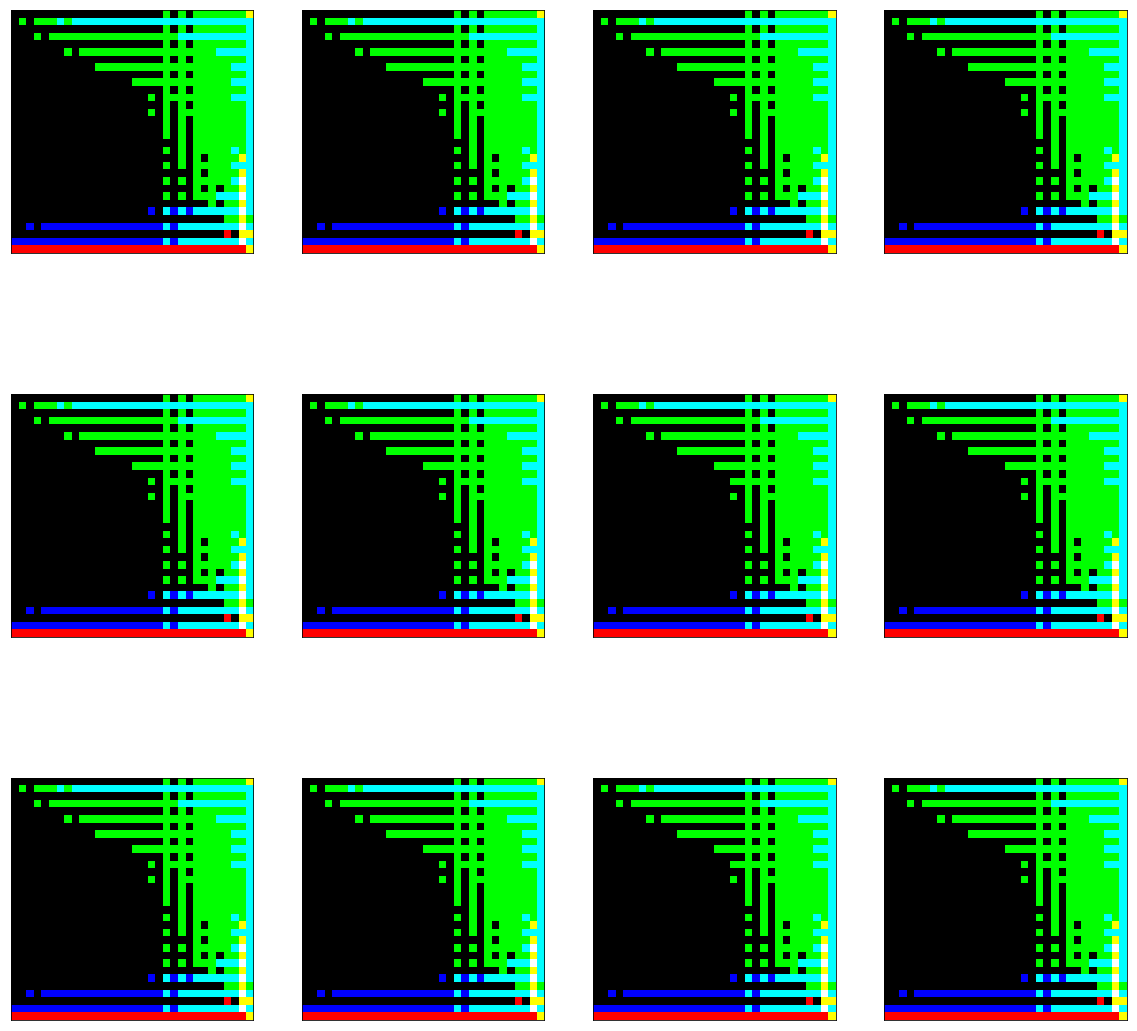

In [7]:
n = 12

z = np.random.randn(n, input_dim) #Jouke: why take a normal distribution over the input?
y = decoder.predict(z)

fig = plt.figure(figsize=(20, 20))
# plot several images
for i in range(n):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(y[i,...])
    
plt.savefig('random-images.pdf')